# Model Performance Comparison: Standard vs Quantized

This notebook compares performance between standard and quantized Qwen2.5-0.5B-Instruct models on calendar parsing tasks.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

1. Set up model loading functions

In [2]:
def load_standard_model():
    """Load the standard model"""
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype="auto",
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    return model, tokenizer

def load_quantized_model():
    """Load the quantized model"""
    model_id = "Qwen/Qwen2.5-0.5B-Instruct-GGUF"
    filename = "qwen2.5-0.5b-instruct-q8_0.gguf"
    
    tokenizer = AutoTokenizer.from_pretrained(model_id, gguf_file=filename)
    model = AutoModelForCausalLM.from_pretrained(model_id, gguf_file=filename)
    
    return model, tokenizer

In [3]:
print("Loading standard model...")
std_model, std_tokenizer = load_standard_model()
print("Standard model loaded!")

print("Loading quantized model...")
quant_model, quant_tokenizer = load_quantized_model()
print("Quantized model loaded!")

Loading standard model...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Standard model loaded!
Loading quantized model...


Converting and de-quantizing GGUF tensors...:   0%|          | 0/291 [00:00<?, ?it/s]

Quantized model loaded!


2. Create test datasets from taxonomy examples

In [4]:
def create_test_datasets():
    """Create test datasets from taxonomy examples"""
    
    simple_examples = [
        "in 2 days",
        "tomorrow 10am",
        "next monday",
        "next week friday 3pm",
        "noon",
        "last friday of the month"
    ]
    
    recurring_examples = [
        "every wed 2pm",
        "every weekday 9am-10am",
        "every 10 minutes between 2 and 7pm",
        "every third friday of month 9am"
    ]
    
    date_time_examples = [
        "2-3:30pm last fri of month",
        "5-6pm tuesday",
        "from 6 til 8pm wed",
        "halloween 9pm",
        "christmas eve 2pm"
    ]
    
    complex_examples = [
        "weekdays minus thursday",
        "every tues unless 1st week of month",
        "first mon of next quarter",
        "every 15 minutes from 1600-1800 on weekdays",
        "weekly on friday from 18 jun til 20 oct"
    ]
    
    timezone_examples = [
        "2:38pm in hawaii",
        "8pm EST",
        "9:19am madrid time",
        "GMT+1 1200"
    ]
    
    reminder_examples = [
        "remind 30m before 10am",
        "aug 9th 7pm rem 1hr",
        "sat 9am, sun 10am, tue 330pm remind 15m before"
    ]
    
    datasets = {
        "Simple": simple_examples,
        "Recurring": recurring_examples,
        "DateTime": date_time_examples,
        "Complex": complex_examples,
        "Timezone": timezone_examples,
        "Reminder": reminder_examples
    }
    
    return datasets

test_datasets = create_test_datasets()

3. Define metrics for comparison

In [5]:
def generate_calendar_output(model, tokenizer, prompt_text, reference_date="Today is 20250311T124823"):
    """Generate calendar output for a given prompt"""
    
    full_prompt = f'''Generate the following ics calendar variables for a given time. 
Example: "tomorrow morning, Today is 20240311T124823"
Output:
DTSTART: 20240312T090000
DTEND: 20240312T100000

Prompt: "{prompt_text} {reference_date}"
Output:
'''
    
    messages = [
        {"role": "system", "content": "You are a calendar assistant that generates iCalendar format variables."},
        {"role": "user", "content": full_prompt}
    ]
    
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    start_time = time.time()
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    generation_time = time.time() - start_time
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return response, generation_time

# Define metrics
def evaluate_model(model, tokenizer, datasets, model_name="Model"):
    """Evaluate model performance on various datasets"""
    
    results = {
        "Category": [],
        "Prompt": [],
        "Response": [],
        "Generation Time (s)": [],
        "Valid Output": [],
        "Has DTSTART": [],
        "Has DTEND or DURATION": [],
        "Has RRULE (if recurring)": [],
        "Has VALARM (if reminder)": []
    }
    
    total_examples = sum(len(examples) for examples in datasets.values())
    print(f"Evaluating {model_name} on {total_examples} examples...")
    
    # Process each dataset
    for category, examples in datasets.items():
        for prompt in examples:
            response, gen_time = generate_calendar_output(model, tokenizer, prompt)
            
            # Basic validation checks
            valid_output = any(field in response for field in ["DTSTART:", "DTEND:", "DURATION:", "RRULE:", "VALARM:"])
            has_dtstart = "DTSTART:" in response
            has_dtend_or_duration = any(field in response for field in ["DTEND:", "DURATION:"])
            has_rrule = "RRULE:" in response
            has_valarm = "VALARM:" in response or "TRIGGER:" in response
            
            # Store results
            results["Category"].append(category)
            results["Prompt"].append(prompt)
            results["Response"].append(response)
            results["Generation Time (s)"].append(gen_time)
            results["Valid Output"].append(valid_output)
            results["Has DTSTART"].append(has_dtstart)
            results["Has DTEND or DURATION"].append(has_dtend_or_duration)
            results["Has RRULE (if recurring)"].append(has_rrule if category == "Recurring" else None)
            results["Has VALARM (if reminder)"].append(has_valarm if category == "Reminder" else None)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    return df

4. Run the comparison

In [6]:
# Run evaluations
print("Starting evaluation...")

std_results = evaluate_model(std_model, std_tokenizer, test_datasets, "Standard Model")
print("Standard model evaluation complete!")

quant_results = evaluate_model(quant_model, quant_tokenizer, test_datasets, "Quantized Model")
print("Quantized model evaluation complete!")

# Save results to CSV for later analysis
std_results.to_csv("standard_model_results.csv", index=False)
quant_results.to_csv("quantized_model_results.csv", index=False)

Starting evaluation...
Evaluating Standard Model on 27 examples...
Standard model evaluation complete!
Evaluating Quantized Model on 27 examples...
Quantized model evaluation complete!


5. Analysis and Visualisation

Overall Performance:
                   Standard   Quantized
Avg Time (s)       9.292210    7.040872
Valid Output %    81.481481  100.000000
DTSTART %         70.370370  100.000000
DTEND/DURATION %  70.370370  100.000000

Category Performance:
           Standard Valid %  Quantized Valid %  Standard Time (s)  \
Simple            83.333333              100.0           7.473188   
Recurring         75.000000              100.0          10.389169   
DateTime         100.000000              100.0           8.275317   
Complex           40.000000              100.0          13.793470   
Timezone         100.000000              100.0           6.565842   
Reminder         100.000000              100.0           9.295519   

           Quantized Time (s)  
Simple               5.262665  
Recurring            7.726172  
DateTime             5.935355  
Complex              8.464041  
Timezone             7.597464  
Reminder             8.412008  


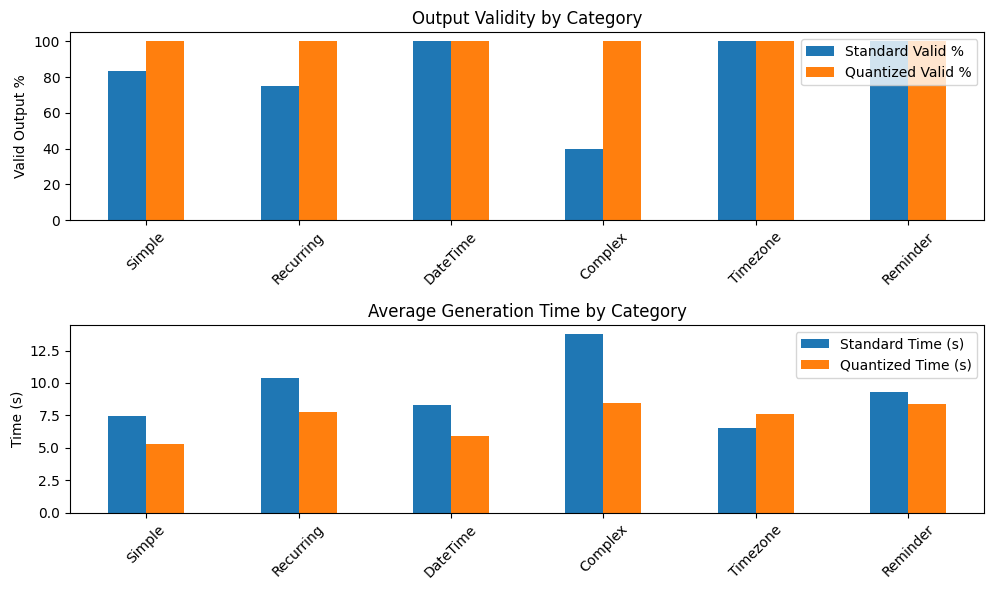


Examples with largest performance difference (time):
                                            Prompt   Category  Std Time (s)  \
8               every 10 minutes between 2 and 7pm  Recurring      6.131974   
22                              9:19am madrid time   Timezone      7.156670   
21                                         8pm EST   Timezone      6.470795   
17                       first mon of next quarter    Complex      6.854918   
26  sat 9am, sun 10am, tue 330pm remind 15m before   Reminder     11.962600   

    Quant Time (s)  Time Diff %  
8        10.096750    64.657426  
22       10.233666    42.994814  
21        8.844335    36.680800  
17        8.777874    28.052209  
26       13.259250    10.839200  

Examples where models disagree on validity:
                                     Prompt   Category  Std Valid  Quant Valid
1                             tomorrow 10am     Simple      False         True
9           every third friday of month 9am  Recurring      Fals

In [7]:
# Analysis and visualization
def analyze_results(std_df, quant_df):
    """Analyze and visualize comparison results"""
    
    # Performance metrics
    metrics = {
        "Standard": {
            "Avg Time (s)": std_df["Generation Time (s)"].mean(),
            "Valid Output %": std_df["Valid Output"].mean() * 100,
            "DTSTART %": std_df["Has DTSTART"].mean() * 100,
            "DTEND/DURATION %": std_df["Has DTEND or DURATION"].mean() * 100
        },
        "Quantized": {
            "Avg Time (s)": quant_df["Generation Time (s)"].mean(),
            "Valid Output %": quant_df["Valid Output"].mean() * 100,
            "DTSTART %": quant_df["Has DTSTART"].mean() * 100,
            "DTEND/DURATION %": quant_df["Has DTEND or DURATION"].mean() * 100
        }
    }
    
    # Create comparison DataFrames
    metrics_df = pd.DataFrame(metrics)
    print("Overall Performance:")
    print(metrics_df)
    
    # Category breakdown
    category_metrics = {}
    for category in std_df["Category"].unique():
        std_cat = std_df[std_df["Category"] == category]
        quant_cat = quant_df[quant_df["Category"] == category]
        
        category_metrics[category] = {
            "Standard Valid %": std_cat["Valid Output"].mean() * 100,
            "Quantized Valid %": quant_cat["Valid Output"].mean() * 100,
            "Standard Time (s)": std_cat["Generation Time (s)"].mean(),
            "Quantized Time (s)": quant_cat["Generation Time (s)"].mean(),
        }
    
    category_df = pd.DataFrame(category_metrics).T
    print("\nCategory Performance:")
    print(category_df)
    
    # Example-level comparison
    comparison = pd.DataFrame({
        "Prompt": std_df["Prompt"],
        "Category": std_df["Category"],
        "Std Time (s)": std_df["Generation Time (s)"],
        "Quant Time (s)": quant_df["Generation Time (s)"],
        "Time Diff %": (quant_df["Generation Time (s)"] - std_df["Generation Time (s)"]) / std_df["Generation Time (s)"] * 100,
        "Std Valid": std_df["Valid Output"],
        "Quant Valid": quant_df["Valid Output"],
        "Std Response": std_df["Response"],
        "Quant Response": quant_df["Response"]
    })
    
    # Visualization
    plt.figure(figsize=(10, 6))
    
    # Plot 1: Performance by category
    plt.subplot(2, 1, 1)
    category_df[["Standard Valid %", "Quantized Valid %"]].plot(kind="bar", ax=plt.gca())
    plt.title("Output Validity by Category")
    plt.ylabel("Valid Output %")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Plot 2: Generation time by category
    plt.subplot(2, 1, 2)
    category_df[["Standard Time (s)", "Quantized Time (s)"]].plot(kind="bar", ax=plt.gca())
    plt.title("Average Generation Time by Category")
    plt.ylabel("Time (s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.savefig("model_comparison_results.png")
    plt.show()
    
    return comparison

# Analyze results
comparison_df = analyze_results(std_results, quant_results)

# Show most interesting comparisons
print("\nExamples with largest performance difference (time):")
print(comparison_df.sort_values("Time Diff %", ascending=False).head(5)[["Prompt", "Category", "Std Time (s)", "Quant Time (s)", "Time Diff %"]])

print("\nExamples where models disagree on validity:")
disagreement = comparison_df[comparison_df["Std Valid"] != comparison_df["Quant Valid"]]
print(disagreement[["Prompt", "Category", "Std Valid", "Quant Valid"]])

# Full comparison available in DataFrame
print("\nFull comparison results saved to 'comparison_results.csv'")
comparison_df.to_csv("comparison_results.csv", index=False)

6. Error Analysis Function

In [ ]:
def analyze_errors(comparison_df):
    """Perform detailed error analysis on model outputs"""
    
    # Define patterns we expect to see in valid outputs
    expected_patterns = {
        "DateTime Format": r"\d{8}T\d{6}",  # Looks for YYYYMMDDTHHMMSS format
        "RRULE Format": r"FREQ=(DAILY|WEEKLY|MONTHLY|YEARLY)",
        "BYDAY Format": r"BYDAY=(MO|TU|WE|TH|FR|SA|SU)",
        "VALARM Format": r"TRIGGER:-PT\d+[HM]",
        "Duration Format": r"PT\d+[HM]"
    }
    
    import re
    
    # Check for each pattern
    for pattern_name, pattern in expected_patterns.items():
        comparison_df[f"Std_{pattern_name}"] = comparison_df["Std Response"].apply(
            lambda x: bool(re.search(pattern, x)) if isinstance(x, str) else False
        )
        comparison_df[f"Quant_{pattern_name}"] = comparison_df["Quant Response"].apply(
            lambda x: bool(re.search(pattern, x)) if isinstance(x, str) else False
        )
    
    # Analyze format errors
    format_errors = pd.DataFrame({
        pattern_name: {
            "Std_Errors": (~comparison_df[f"Std_{pattern_name}"]).sum(),
            "Quant_Errors": (~comparison_df[f"Quant_{pattern_name}"]).sum(),
            "Difference": (~comparison_df[f"Quant_{pattern_name}"]).sum() - (~comparison_df[f"Std_{pattern_name}"]).sum()
        } for pattern_name in expected_patterns.keys()
    }).T
    
    print("Format Error Analysis:")
    print(format_errors)
    
    # Check for consistent date-time calculations
    def extract_datetime(response):
        match = re.search(r"DTSTART:.*?(\d{8}T\d{6})", response)
        return match.group(1) if match else None
    
    comparison_df["Std_DateTime"] = comparison_df["Std Response"].apply(extract_datetime)
    comparison_df["Quant_DateTime"] = comparison_df["Quant Response"].apply(extract_datetime)
    comparison_df["Same_DateTime"] = comparison_df.apply(
        lambda row: row["Std_DateTime"] == row["Quant_DateTime"] 
        if row["Std_DateTime"] and row["Quant_DateTime"] else None, 
        axis=1
    )
    
    # Fix: Count different date calculations more safely
    datetime_consistency = {
        "Total_With_DateTime": comparison_df["Same_DateTime"].notna().sum(),
        "Matching_DateTime": comparison_df["Same_DateTime"].fillna(False).sum(),
        "Different_DateTime": ((comparison_df["Same_DateTime"] == False) & comparison_df["Same_DateTime"].notna()).sum()
    }
    
    print("\nDate-Time Calculation Consistency:")
    print(pd.Series(datetime_consistency))
    
    # Examples with different datetime calculations
    if datetime_consistency["Different_DateTime"] > 0:
        print("\nExamples with different datetime calculations:")
        dt_diff = comparison_df[(comparison_df["Same_DateTime"] == False) & comparison_df["Same_DateTime"].notna()]
        print(dt_diff[["Prompt", "Category", "Std_DateTime", "Quant_DateTime"]])
    
    return format_errors

7. Case-by-case analysis for complex expressions

In [11]:
def compare_specific_cases():
    """Compare models on specific challenging cases from the taxonomy"""
    
    # Select challenging expressions from the taxonomy
    challenging_cases = [
        "first mon of next quarter",
        "weekdays minus thursday",
        "every 15 minutes from 1600-1800 on weekdays",
        "every tues unless 1st week of month",
        "weekly on friday from 18 jun til 20 oct",
        "sat 9am, sun 10am, tue 330pm remind 15m before"
    ]
    
    # Test both models on these cases
    results = []
    for prompt in challenging_cases:
        std_response, std_time = generate_calendar_output(std_model, std_tokenizer, prompt)
        quant_response, quant_time = generate_calendar_output(quant_model, quant_tokenizer, prompt)
        
        results.append({
            "Prompt": prompt,
            "Standard Response": std_response,
            "Standard Time": std_time,
            "Quantized Response": quant_response,
            "Quantized Time": quant_time,
            "Responses Match": std_response == quant_response
        })
    
    # Create DataFrame and display
    case_df = pd.DataFrame(results)
    print("Challenging Case Comparison:")
    print(case_df[["Prompt", "Responses Match", "Standard Time", "Quantized Time"]])
    
    # Display full responses for non-matching cases
    non_matching = case_df[case_df["Responses Match"] == False]
    if len(non_matching) > 0:
        print("\nDetailed view of non-matching responses:")
        for _, row in non_matching.iterrows():
            print(f"\nPrompt: {row['Prompt']}")
            print(f"Standard:\n{row['Standard Response']}")
            print(f"Quantized:\n{row['Quantized Response']}")
    
    return case_df

# Run specific case analysis
case_analysis = compare_specific_cases()

Challenging Case Comparison:
                                           Prompt  Responses Match  \
0                       first mon of next quarter            False   
1                         weekdays minus thursday            False   
2     every 15 minutes from 1600-1800 on weekdays            False   
3             every tues unless 1st week of month            False   
4         weekly on friday from 18 jun til 20 oct            False   
5  sat 9am, sun 10am, tue 330pm remind 15m before            False   

   Standard Time  Quantized Time  
0      10.004570        7.781791  
1       7.286892        5.353466  
2      13.007425       11.727710  
3     206.263495        6.459590  
4      31.464860        9.263470  
5      11.890718       11.598559  

Detailed view of non-matching responses:

Prompt: first mon of next quarter
Standard:
```ical
DTSTART: 20250312T090000
DTEND: 20250312T100000
RRULE:FREQ=WEEKLY;BYDAY=MO;BYHOUR=9;WEEKSTART=1
```
Quantized:
DTSTART: 20250312T090000
DTEN